<a href="https://colab.research.google.com/github/alvaroacebes/repository1/blob/main/HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introducción**

In [ ]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install sktime
!pip install pmdarima

In [ ]:
# Read Data
app_df = pd.read_csv('/content/aapl_ok.csv',sep=';')
app_df['fecha'] = pd.to_datetime(app_df['fecha'])
app_df = app_df.set_index('fecha')
app_df.head()





,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,"1493,4"
1990-03-30,Q2 1990,"1346,2"
1990-06-29,Q3 1990,"1364,8"
1990-09-28,Q4 1990,"1354,1"
1990-12-28,Q1 1991,"1675,5"


Convertimos los datos en trimestrales

In [ ]:
# Resample to Quarterly I
app_ts=app_df.resample("q").last()
app_ts.tail()


,Trimeste,Ingresos
fecha,,
2020-06-30,Q3 2020,59685
2020-09-30,Q4 2020,64698
2020-12-31,Q1 2021,111439
2021-03-31,Q2 2021,89584
2021-06-30,Q3 2021,81434


In [ ]:
# Resample to Quarterly II
# SKtime format
app_df['Ingresos'] = app_df['Ingresos'].str.replace(',', '.')
app_ts_q=app_df['Ingresos'].astype('float64').to_period('Q').sort_index()
app_ts_q.tail()


fecha
2020Q2     59685.0
2020Q3     64698.0
2020Q4    111439.0
2021Q1     89584.0
2021Q2     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

# **SOLUCIÓN**

Graficar los Ingresos


Text(0, 0.5, 'Ventas Apple')

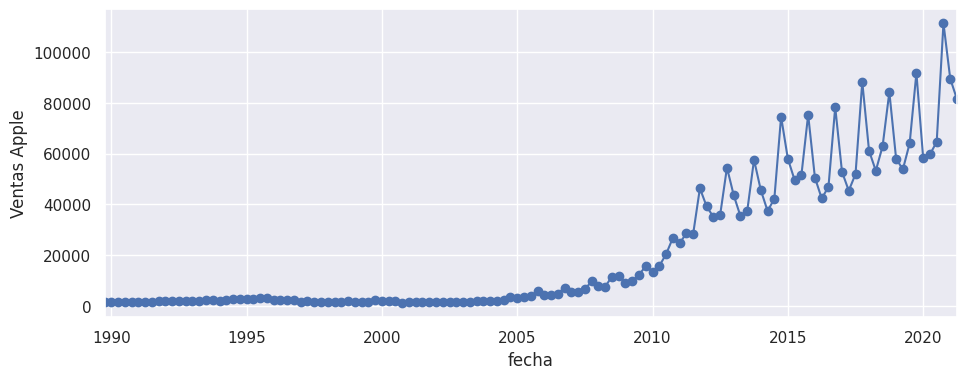

In [ ]:
# Plot Data
# Use seaborn style defaults and set the default figure size

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
ax = app_ts_q.plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas Apple')



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

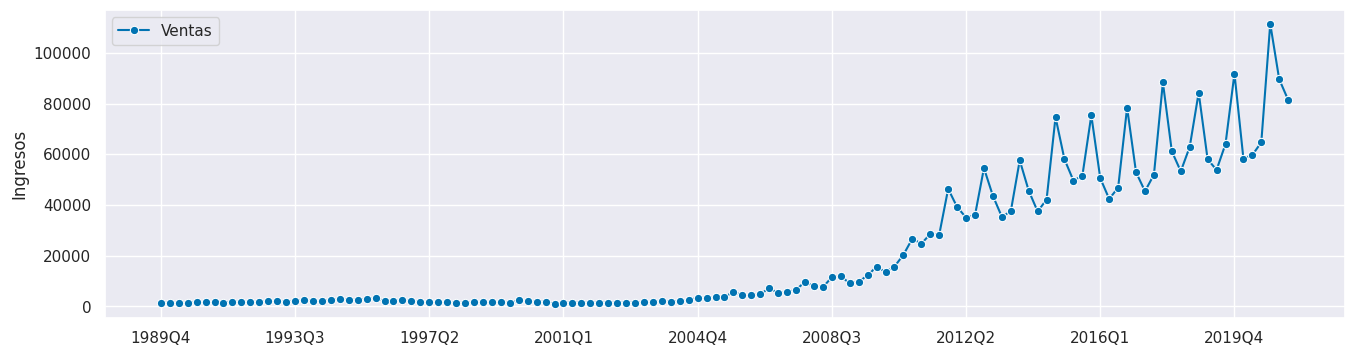

In [ ]:
# Plot Data
# Use Sktime style
from sktime.utils.plotting import plot_series
plot_series(app_ts_q, labels=["Ventas"])

# **No estacionariedad en Varianza**

Calculamos la transformacion logarítmica de la Serie Original

In [ ]:
# Log Transformer Function
from sktime.transformations.series.boxcox import LogTransformer

In [ ]:
# Apply Log Transformer

transformer = LogTransformer()
log_app_ts= transformer.fit_transform(app_ts_q)
log_app_ts.tail()

2020Q2    10.996836
2020Q3    11.077486
2020Q4    11.621233
2021Q1    11.402932
2021Q2    11.307548
Freq: Q-DEC, Name: Ingresos, dtype: float64

Text(0.5, 1.0, 'Ventas Apple: Transformación LOG')

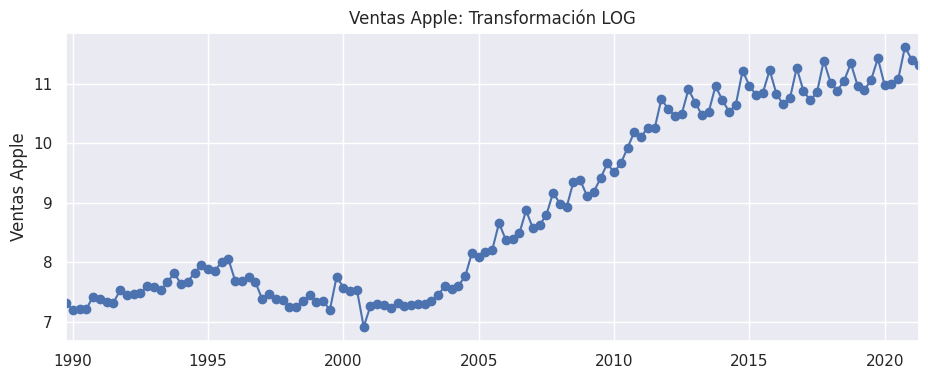

In [ ]:
# Plot Log Data
ax = log_app_ts.plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas Apple')
ax.set_title('Ventas Apple: Transformación LOG')

Text(0.5, 1.0, 'Ventas Apple: Transformación LOG')

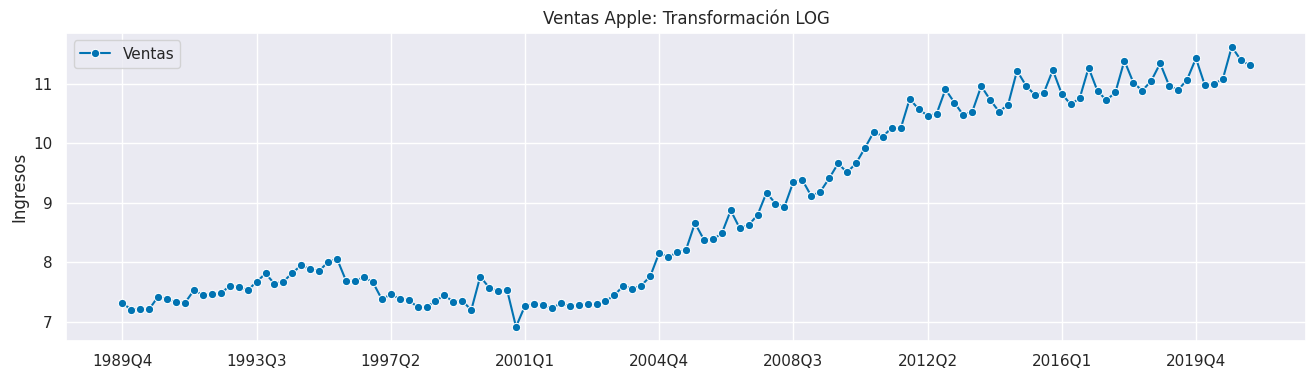

In [ ]:
# Plot Log Data
fig, ax =plot_series(log_app_ts, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación LOG')

# **No estacionariedad en Varianza**

Comparamos la transformacion logarítmica de la Serie Original y la Serie en Logs

Text(0.5, 1.0, 'Ventas Apple: Transformación LOG')

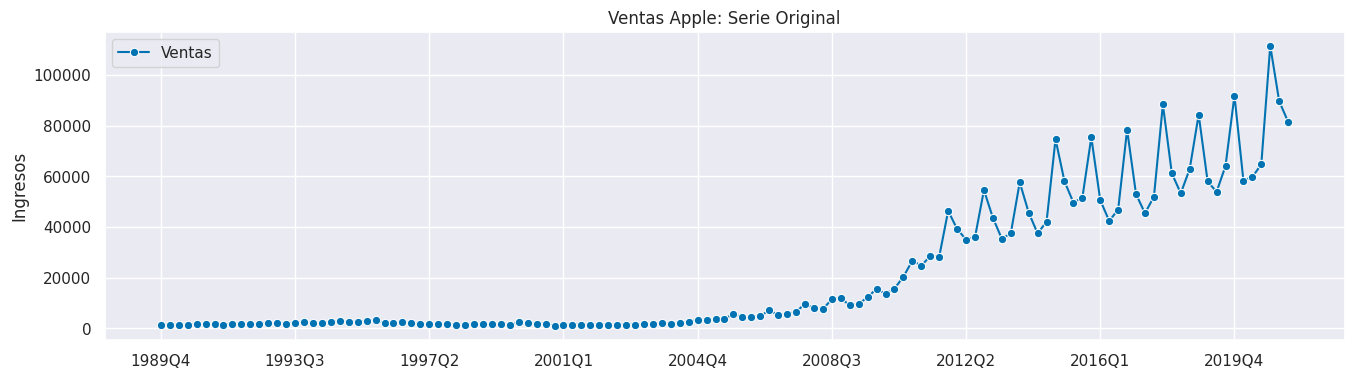

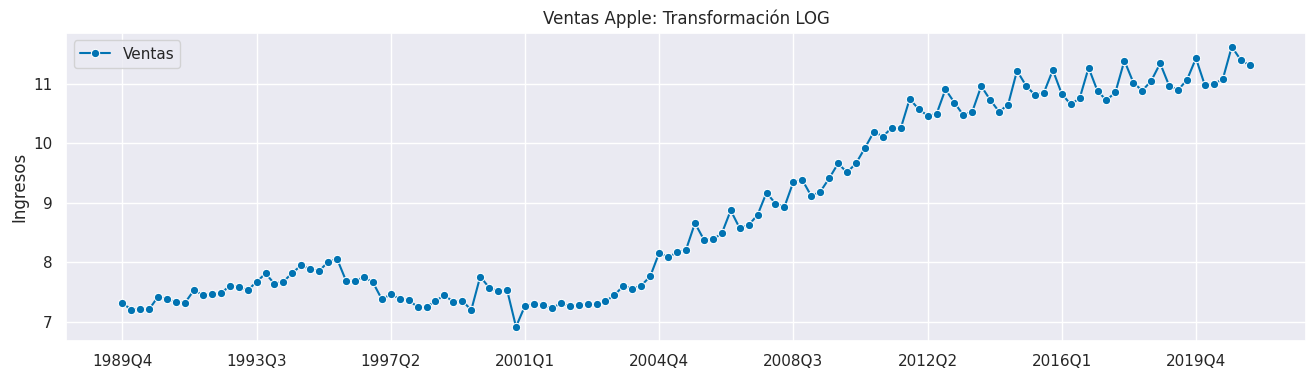

In [ ]:
# Plot Log Data & Original Data
fig, ax =plot_series(app_ts_q, labels=["Ventas"])
ax.set_title('Ventas Apple: Serie Original')
fig, ax =plot_series(log_app_ts, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación LOG')

# **Autocorrelación**

Calculamos la Autocorrelación de la Serie en Logs


In [ ]:
# Autocorrelation Fuction Package
from sktime.utils.plotting import plot_correlations

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

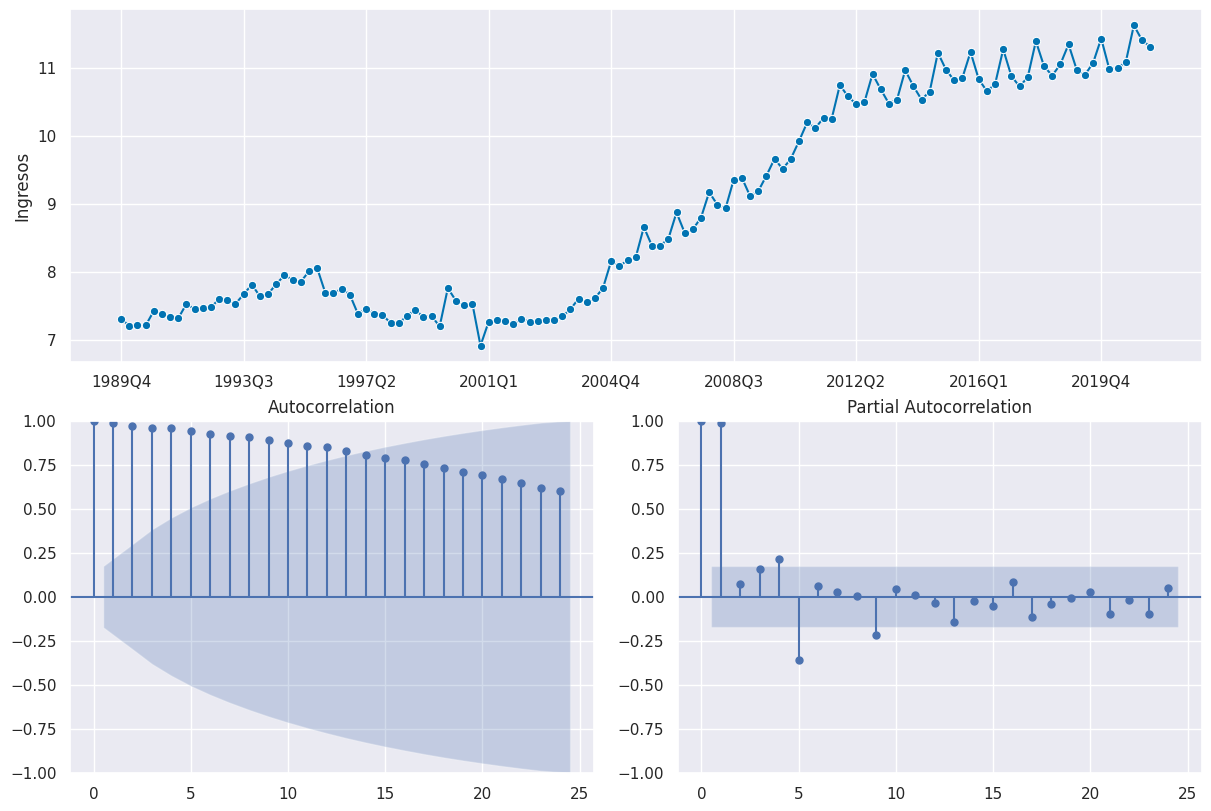

In [ ]:
# Autocorrelation Fuction Original Time Series
plot_correlations(log_app_ts)

In [ ]:
# Difference Fuction Package
from sktime.transformations.series.difference import Differencer

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

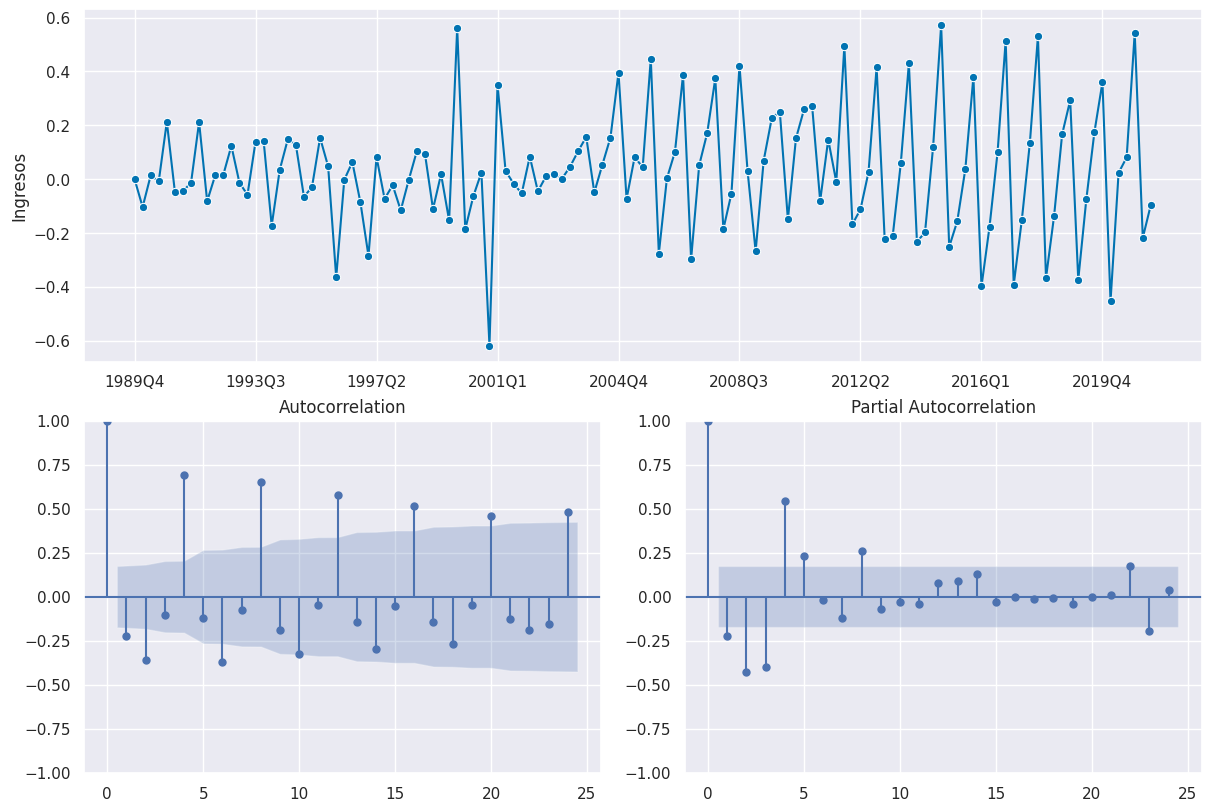

In [ ]:
# Autocorrelation Fuction
# d=1; D=0; S=4
#
transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(log_app_ts))

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

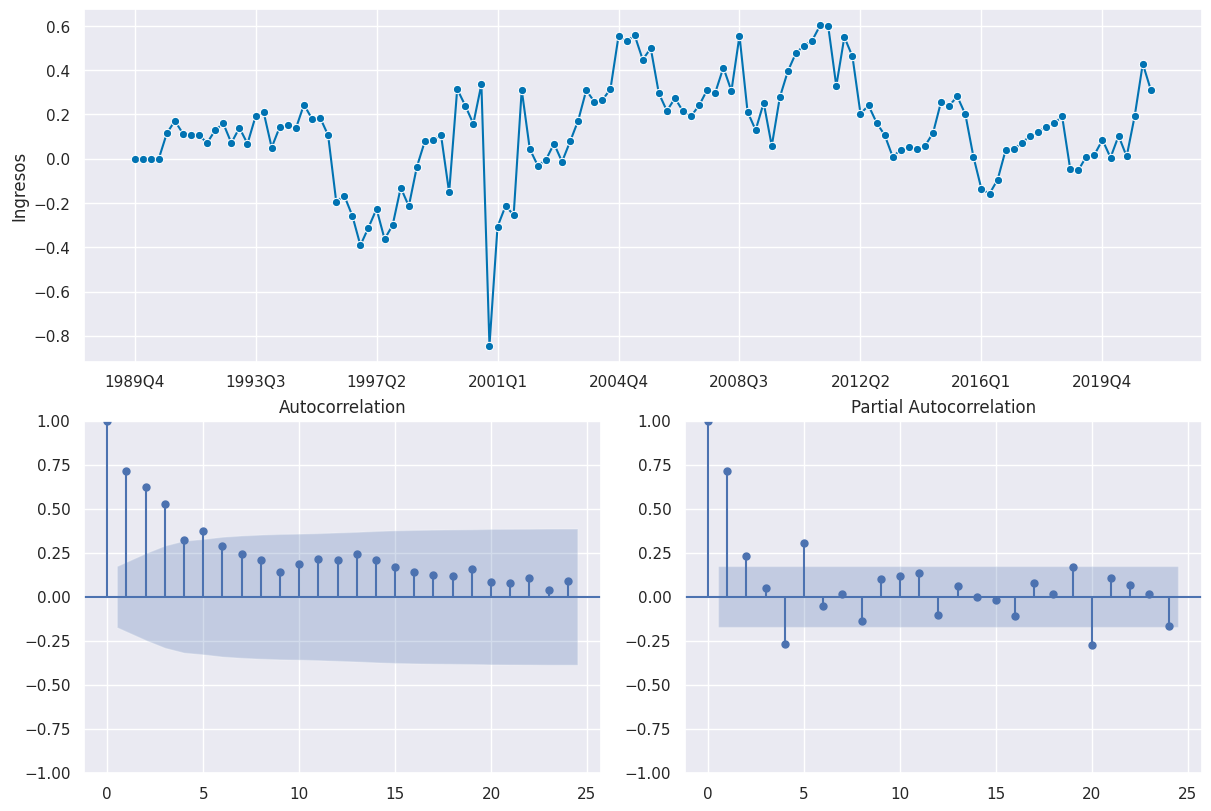

In [ ]:
# Autocorrelation Fuction
# d=0; D=1; S=4
#
transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(log_app_ts))

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Ingresos'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

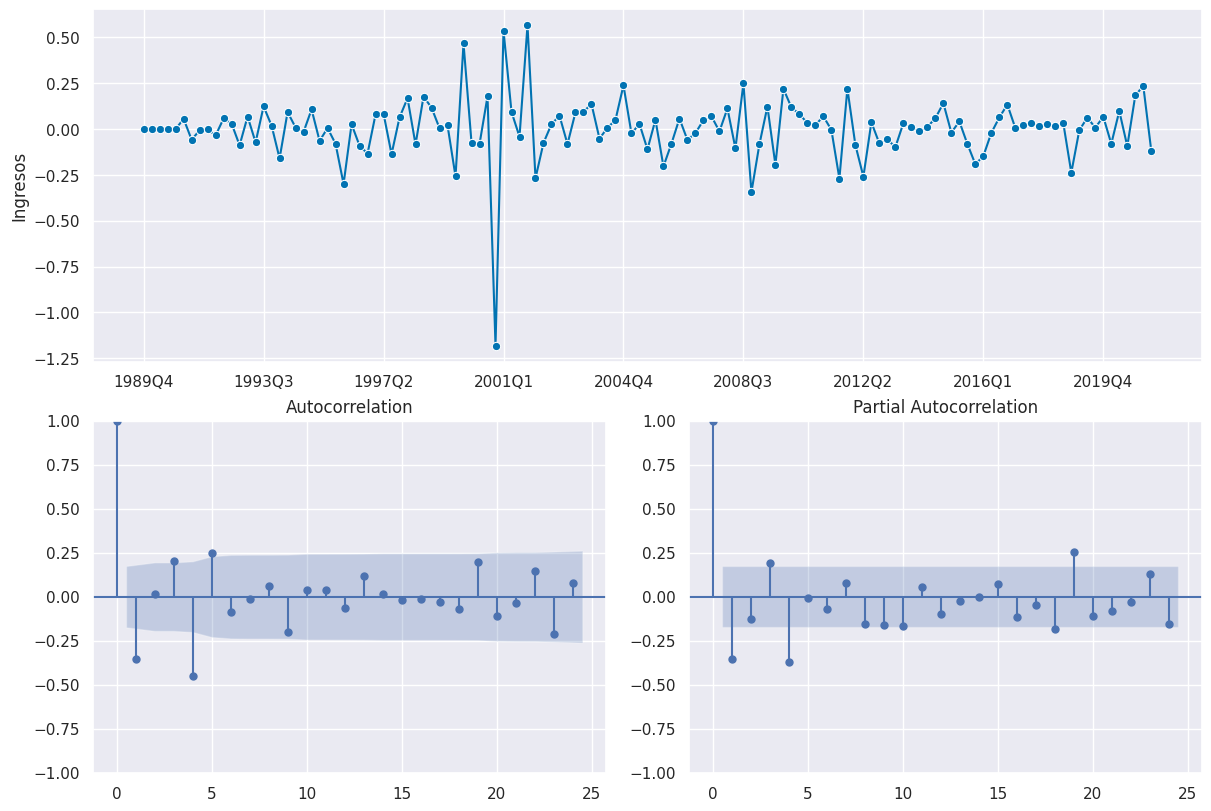

In [ ]:
# Autocorrelation Fuction
# d=1; D=1; S=4
#
transf_diff=Differencer(lags=[1,4])
plot_correlations(transf_diff.fit_transform(log_app_ts))

# **Modelos ARIMA**


Vamos a separar la muestra en la parte de estiamción (Training) y la parte de predicción/Verificación (Testing). Quitamos 8 trimestres.

Vamos a predecir 8 periodos (h=8)

In [ ]:
# Sktime fucntions
# Forecast horizon and Split function
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

119 8


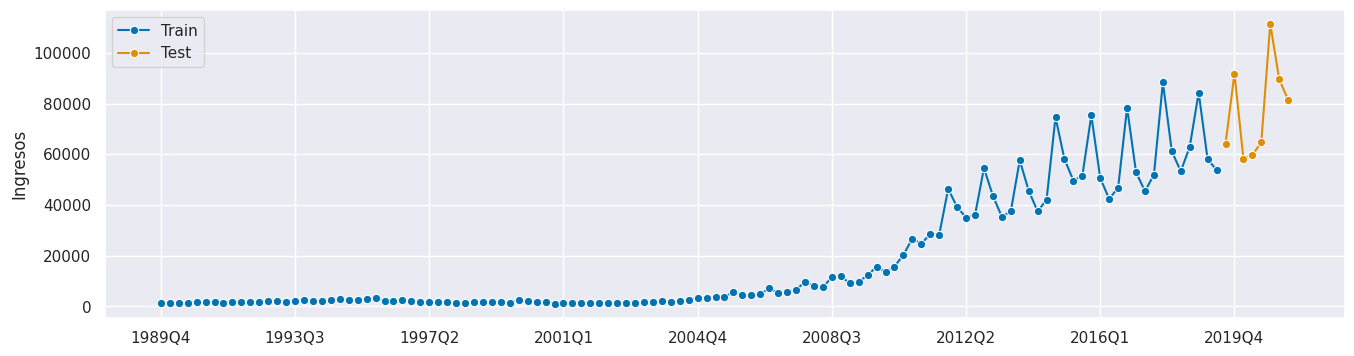

In [ ]:
# Select Train & test sample
# we will try to forecast y_test from y_train
# plotting for illustration
# original and log samples
y_train, y_test = temporal_train_test_split(y =app_ts_q, test_size=8)
log_y_train, log_y_test = temporal_train_test_split(y =log_app_ts, test_size=8)
plot_series(y_train, y_test, labels=["Train", "Test"])
# Time Series Size
print(y_train.shape[0], y_test.shape[0])

In [ ]:
# Forecast Horizon
fh = np.arange(len(y_test)) + 1  # forecasting horizon
fh

array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# Sktime Auto ARIMA Function
from sktime.forecasting.arima import AutoARIMA

In [ ]:
#  Auto ARIMA Model

forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [ ]:
#  Auto ARIMA Model Summary
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.362
Date:                           Mon, 09 Oct 2023   AIC                           -108.724
Time:                                   09:37:09   BIC                            -97.642
Sample:                               12-31-1989   HQIC                          -104.224
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.822

In [ ]:
#  Auto ARIMA Forecast
log_y_pred = forecaster.predict(fh)
log_y_pred

2019Q3    11.005156
2019Q4    11.335685
2020Q1    11.027218
2020Q2    10.934801
2020Q3    11.039462
2020Q4    11.342086
2021Q1    11.059661
2021Q2    10.975046
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [ ]:
#  Auto ARIMA Forecast
# Original Time series (Invert log transformation)
np.exp(log_y_pred)

2019Q3    60183.674939
2019Q4    83757.822329
2020Q1    61526.178912
2020Q2    56094.939194
2020Q3    62284.140153
2020Q4    84295.715654
2021Q1    63555.016644
2021Q2    58398.541302
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [ ]:
# Sktime fucntions
# Forecast Accuracy MAPE & MSE & RMSE
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError

In [ ]:
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(log_y_test, log_y_pred)

0.013892973614064611

In [ ]:
# Forecast Accuracy
# MAPE
# Orignal Time Serie

mean_absolute_percentage_error(y_test, np.exp(log_y_pred))

0.13969639733058992

In [ ]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(log_y_test, log_y_pred)

0.20210986175416867

In [ ]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(log_y_pred))

16022.608324659994

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

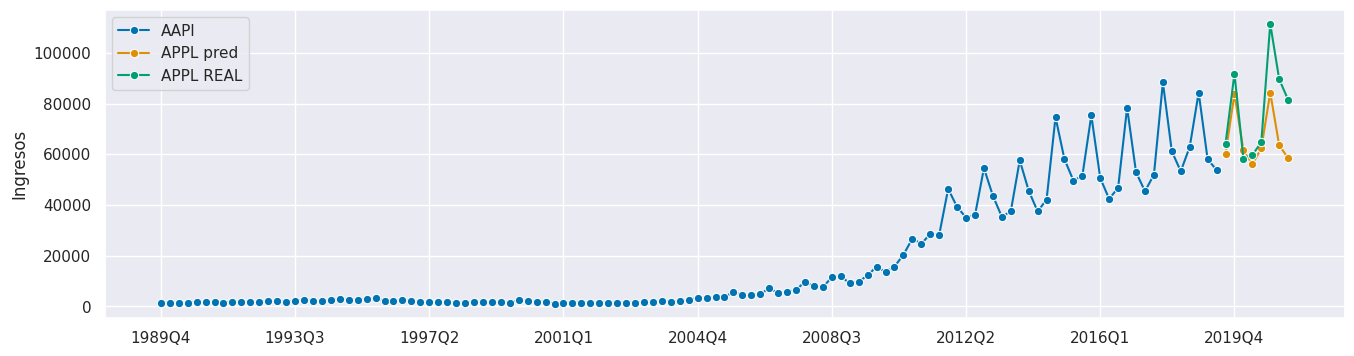

In [ ]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train, np.exp(log_y_pred),y_test, labels=["AAPl", "APPL pred", "APPL REAL"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

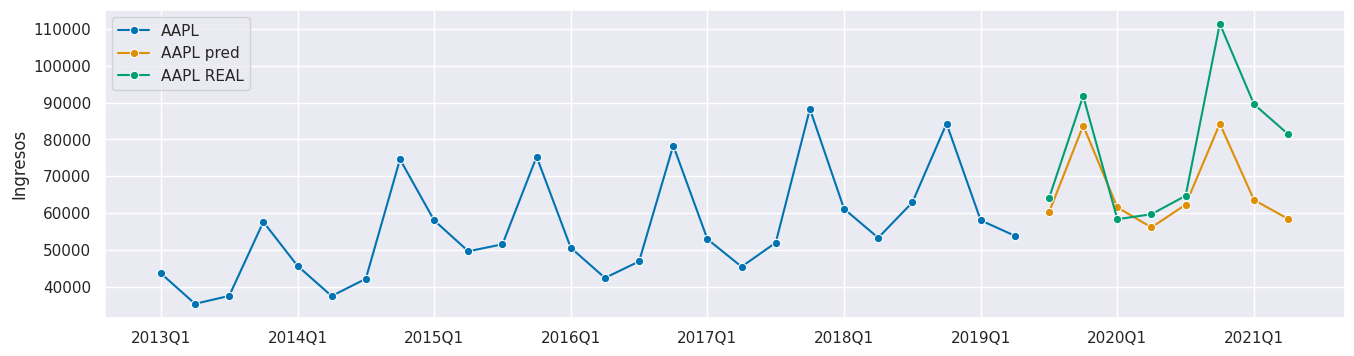

In [ ]:
# Forecast Accuracy Plot
# Plotting predictions and past data
# Zoom 2013 -2021
plot_series(y_train["2013":], np.exp(log_y_pred),y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])

Vamos a predecir 6 periodos (h=6), lo que resta del 2021 y el 2022

In [ ]:
# Forecast Horizon
fh = np.arange(6) + 1 # forecasting horizon
fh

array([1, 2, 3, 4, 5, 6])

In [ ]:
# Auto ARIMA Model
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_app_ts)

AutoARIMA(sp=4, suppress_warnings=True)

In [ ]:
# Auto ARIMA Model Summary
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  127
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 4)   Log Likelihood                  64.270
Date:                             Mon, 09 Oct 2023   AIC                           -118.539
Time:                                     09:37:45   BIC                           -104.358
Sample:                                 12-31-1989   HQIC                          -112.778
                                      - 06-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3231      0.079     -4.096      0.000      -0.478      -0.168
ar.L2         -0.1575      

In [ ]:
# Auto ARIMA Forecast
log_y_pred = forecaster.predict(fh)
log_y_pred

2021Q3    11.406399
2021Q4    11.810566
2022Q1    11.532828
2022Q2    11.470464
2022Q3    11.565873
2022Q4    11.939243
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [ ]:
# Auto ARIMA Forecast
# Original Time series (Invert log transformation)
np.exp(log_y_pred)

2021Q3     89895.159267
2021Q4    134667.710973
2022Q1    102010.214502
2022Q2     95842.759213
2022Q3    105437.402726
2022Q4    153160.635738
Freq: Q-DEC, Name: Ingresos, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

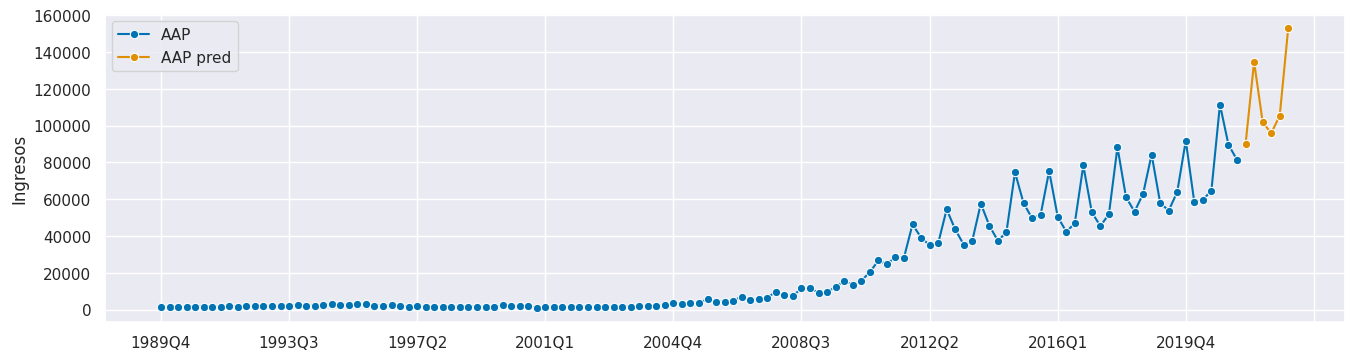

In [ ]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(app_ts_q, np.exp(log_y_pred), labels=["AAP", "AAP pred"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ingresos'>)

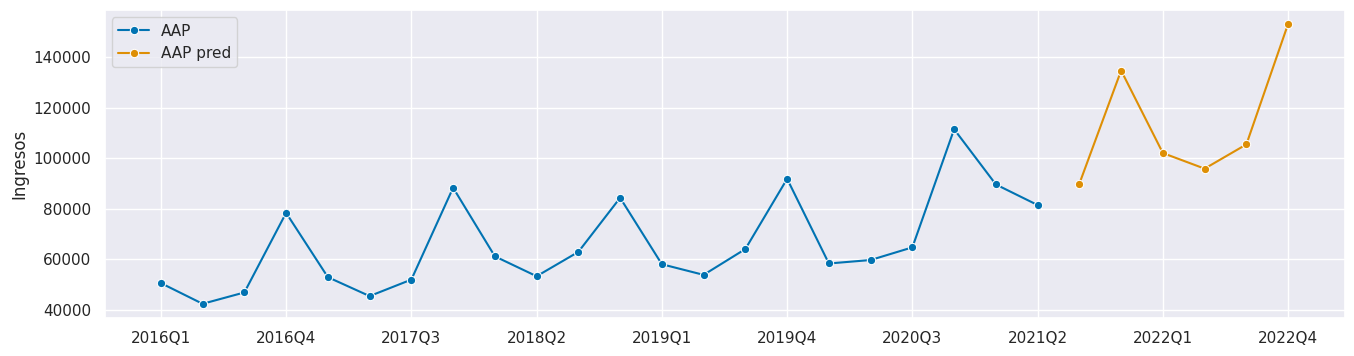

In [ ]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(app_ts_q["2016":], np.exp(log_y_pred), labels=["AAP", "AAP pred"])